# Тема “Классификация текста”

В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

from wordcloud import WordCloud
import collections
import matplotlib.pyplot as plt

In [2]:
SPLIT_INDEX = 31962

In [3]:
with open('../data/data_processed.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
df = df[~df.label.isna()]

In [5]:
df.label.value_counts(normalize=True)

0.0    0.929854
1.0    0.070146
Name: label, dtype: float64

In [6]:
X = df[['tweet_stemmed', 'tweet_lemmatized']]
y = df.label

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)

In [8]:
X_train_count_stemmed =  CountVectorizer(max_features=5000).fit_transform(X_train.tweet_stemmed.astype('str'))
X_test_count_stemmed = CountVectorizer(max_features=5000).fit_transform(X_test.tweet_stemmed.astype('str'))

X_train_count_lemmatized =  CountVectorizer(max_features=5000).fit_transform(X_train.tweet_lemmatized.astype('str'))
X_test_count_lemmatized = CountVectorizer(max_features=5000).fit_transform(X_test.tweet_lemmatized.astype('str'))

X_train_tfidf_stemmed = TfidfVectorizer(max_features=5000).fit_transform(X_train.tweet_stemmed.astype('str'))
X_test_tfidf_stemmed = TfidfVectorizer(max_features=5000).fit_transform(X_test.tweet_stemmed.astype('str'))

X_train_tfidf_lemmatized = TfidfVectorizer(max_features=5000).fit_transform(X_train.tweet_lemmatized.astype('str'))
X_test_tfidf_lemmatized = TfidfVectorizer(max_features=5000).fit_transform(X_test.tweet_lemmatized.astype('str'))

In [9]:
def train_model(model, X_train, y_train, X_test, y_test, metric, threshold=0.5):
    model.fit(X_train, y_train)
    pred_prob = model.predict_proba(X_test)
    y_pred = np.where(pred_prob[:,1] > threshold, 1, 0)
    score = getattr(metrics, metric)(y_test, y_pred)
    return score

In [10]:
model_lr = LogisticRegression()

**Задание 1.**
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [11]:
result = pd.DataFrame(
    columns=(
    'Count Vectorizer Stemmed',
    'Count Vectorizer Lemmatized',
    'TfIdf Vectorizer Stemmed',
    'TfIdf Vectorizer Lemmatized',
    ),
    index=('f1',)
)

In [12]:
result['Count Vectorizer Stemmed'] = train_model(model_lr, X_train_count_stemmed, y_train, X_test_count_stemmed, y_test, 'f1_score', 0.3)
result['Count Vectorizer Lemmatized'] = train_model(model_lr, X_train_count_lemmatized, y_train, X_test_count_lemmatized, y_test, 'f1_score', 0.3)

**Задание 2.**
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [13]:
result['TfIdf Vectorizer Stemmed'] = train_model(model_lr, X_train_tfidf_stemmed, y_train, X_test_tfidf_stemmed, y_test, 'f1_score', 0.3)
result['TfIdf Vectorizer Lemmatized'] = train_model(model_lr, X_train_tfidf_lemmatized, y_train, X_test_tfidf_lemmatized, y_test, 'f1_score', 0.3)

**Задание 3.**
Выведите результаты f1-score всех моделей, сделайте вывод.

In [14]:
result

,Count Vectorizer Stemmed,Count Vectorizer Lemmatized,TfIdf Vectorizer Stemmed,TfIdf Vectorizer Lemmatized
f1,0.027682,0.090523,0.003708,0.012247


**Задание 4.**
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

In [15]:
stop_words = set(stopwords.words("english"))
words = []
for line in df['clean_tweet']: 
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

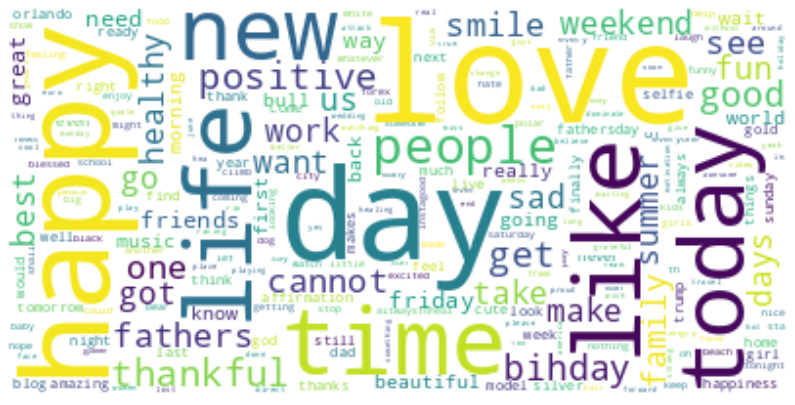

In [16]:
wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Задание 5.**
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

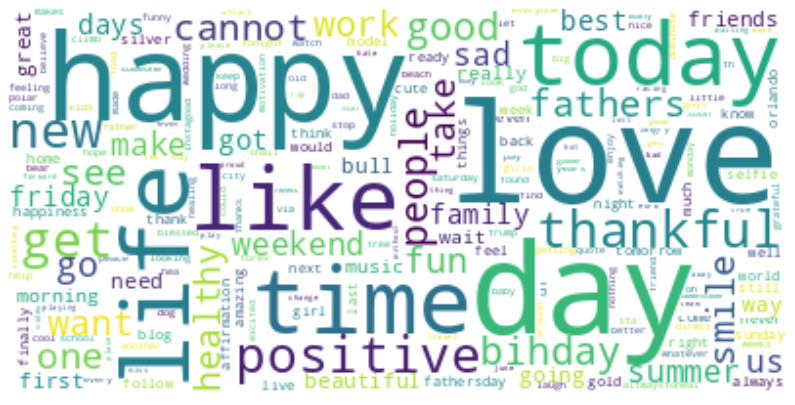

In [17]:
words = []
for line in df.loc[df['label'] == 0, 'clean_tweet']: 
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Задание 6.**
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

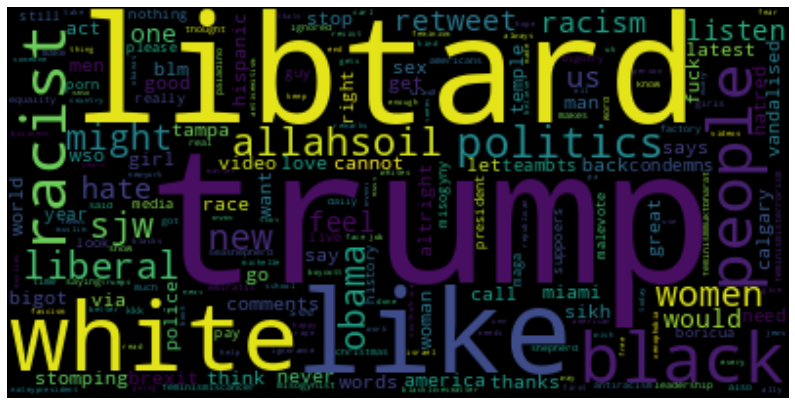

In [18]:
words = []
for line in df.loc[df['label'] == 1, 'clean_tweet']: 
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='black',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()